## 1. Import and Setup

In [6]:
import torch
import numpy as np
import pandas as pd
import os
import json
import sys
sys.path.append("../src")

from config import SEEDS, MODELS_DIR_TEMPORAL
from data_utils_temporal import load_and_preprocess_elliptic_temporal
from train_temporal import train_and_evaluate_temporal
from evaluation_multiseed import full_evaluation_report, visualize_mean_confusion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("All modules imported successfully.")


All modules imported successfully.


## 2. Load and Preprocess the Elliptic Dataset
This loads the data, maps transaction IDs to node indices, filters isolated nodes, and normalizes node features. Uses temporal splitting.


In [7]:
data, node_times = load_and_preprocess_elliptic_temporal()

# Move data to device (GPU or CPU)
data = data.to(device)

print(data)
print(f"Feature shape: {data.x.shape}")
print(f"Total labeled nodes: {(data.y != -1).sum().item()}")


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])
Feature shape: torch.Size([203769, 166])
Total labeled nodes: 46564


## 3. Initialize the GAT Model
Set hyperparameters.

In [8]:
from model_gat import GATNet

# Hyperparameters
hidden_channels = 8
dropout = 0.3
out_channels = 2
heads = 8
in_channels = data.x.shape[1]

# Model initialization
model = GATNet(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    heads=heads,
    dropout=dropout
).to(device)

data = data.to(device)
print(model)

GATNet(
  (gat1): GATConv(166, 8, heads=8)
  (gat2): GATConv(64, 2, heads=1)
)


## 4. Temporal Multiseed Training

In [10]:
from train_temporal import train_and_evaluate_temporal
from config import SEEDS

for seed in SEEDS:
    print(f"Running seed {seed}...")
    train_and_evaluate_temporal(seed, data, node_times, model_type="GAT")

Running seed 42...
Epoch 001 | Loss: 1.2890 | Val Acc: 0.4179 | Val F1: 0.3464
Epoch 002 | Loss: 1.5954 | Val Acc: 0.4352 | Val F1: 0.3587
Epoch 003 | Loss: 1.2746 | Val Acc: 0.4586 | Val F1: 0.3744
Epoch 004 | Loss: 1.4307 | Val Acc: 0.4713 | Val F1: 0.3837
Epoch 005 | Loss: 1.2601 | Val Acc: 0.4836 | Val F1: 0.3926
Epoch 006 | Loss: 1.8787 | Val Acc: 0.4945 | Val F1: 0.3997
Epoch 007 | Loss: 0.8358 | Val Acc: 0.5041 | Val F1: 0.4057
Epoch 008 | Loss: 0.7770 | Val Acc: 0.5096 | Val F1: 0.4091
Epoch 009 | Loss: 0.7062 | Val Acc: 0.5148 | Val F1: 0.4126
Epoch 010 | Loss: 0.6739 | Val Acc: 0.5205 | Val F1: 0.4158
Epoch 011 | Loss: 0.6533 | Val Acc: 0.5256 | Val F1: 0.4190
Epoch 012 | Loss: 0.6281 | Val Acc: 0.5311 | Val F1: 0.4222
Epoch 013 | Loss: 0.6798 | Val Acc: 0.5385 | Val F1: 0.4267
Epoch 014 | Loss: 0.5614 | Val Acc: 0.5464 | Val F1: 0.4316
Epoch 015 | Loss: 0.8055 | Val Acc: 0.5514 | Val F1: 0.4343
Epoch 016 | Loss: 0.5941 | Val Acc: 0.5573 | Val F1: 0.4377
Epoch 017 | Loss: 0.6

## 5. Evaluation and Visualisation
### 5.1 Import and Setup

In [1]:
import sys
sys.path.append("../src")

from evaluation_pipeline import (
    run_inference_all_seeds,
    plot_conf_matrices,
    summarize_classification_report,
    save_fp_fn_indices,
    attach_node_times,
    plot_fp_fn_time_distributions
)

from analysis_utils import (
    load_metrics_across_seeds,
    aggregate_metrics_table,
    plot_loss_curve
)

from model_gat import GATNet
from load_elliptic_data import load_and_preprocess_elliptic_data

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seeds = [42, 123, 777, 2023, 31415]

# Data + Model Config
data = load_and_preprocess_elliptic_data("../elliptic_bitcoin_dataset").to(device)
model_class = GATNet
model_dir = "../model_temporal/GAT"
model_name = "GAT-Temporal"

### 5.2 Load Metric Logs and Loss Curve

,Metric,Mean,Std,Formatted
0,val_acc,0.9396,0.0149,0.9396 ± 0.0149
1,val_f1_macro,0.7357,0.0380,0.7357 ± 0.0380
2,val_f1_illicit,0.9678,0.0082,0.9678 ± 0.0082


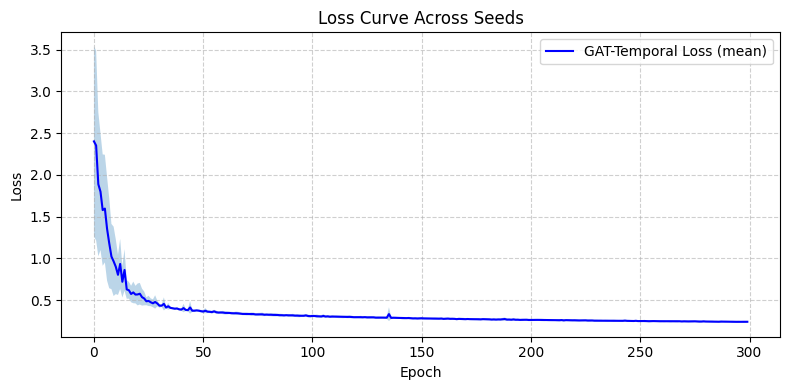

In [2]:
metrics_logs = load_metrics_across_seeds(model_dir, ["val_acc", "val_f1_macro", "val_f1_illicit", "loss"])
summary_df = aggregate_metrics_table(metrics_logs)
display(summary_df)
plot_loss_curve(metrics_logs["loss"], label=model_name + " Loss")


### 5.3 Inference Across Seeds

In [3]:
y_true_all, y_pred_all, y_proba_all, seed_metrics = run_inference_all_seeds(
    model_dir=model_dir,
    model_class=model_class,
    data=data,
    seeds=seeds
)

### 5.4 Confusion Matrices

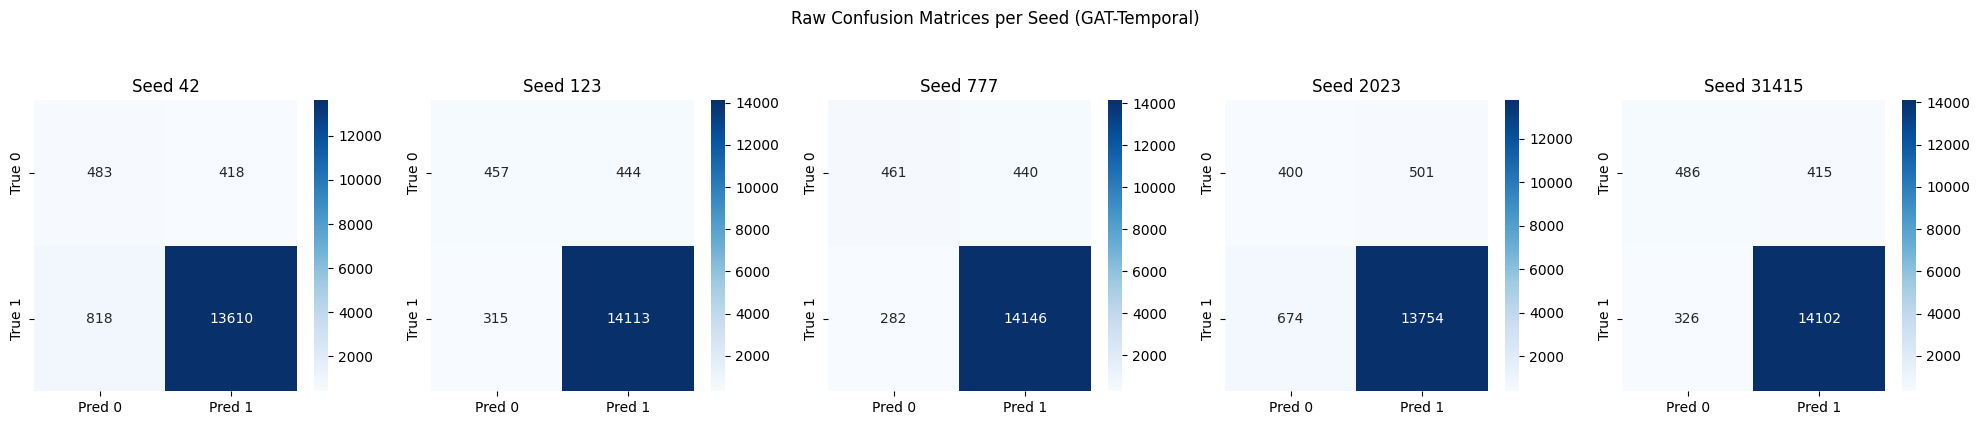

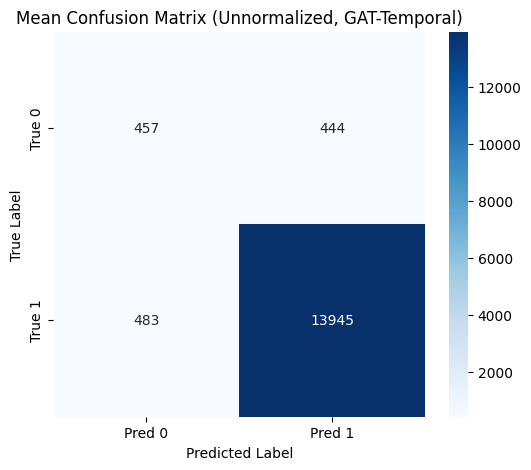

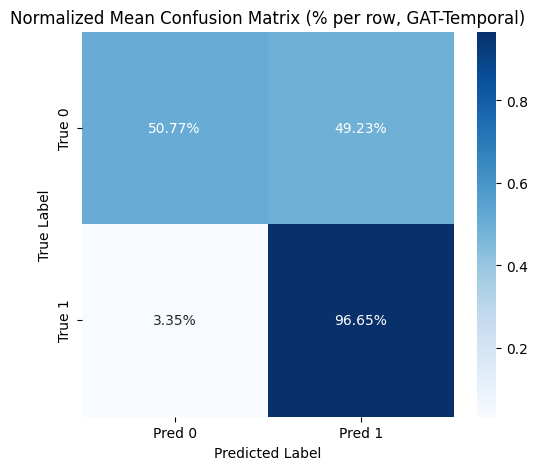

In [4]:
plot_conf_matrices(y_true_all, y_pred_all, seeds, model_name=model_name)

### 5.5 Metric Summary

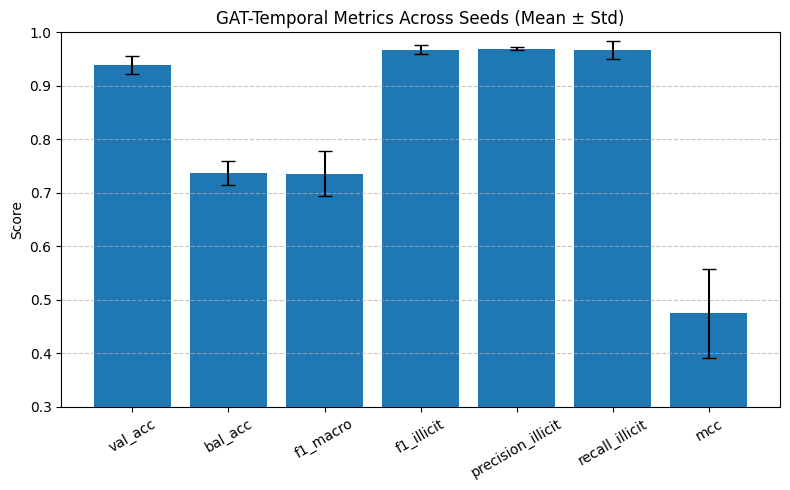

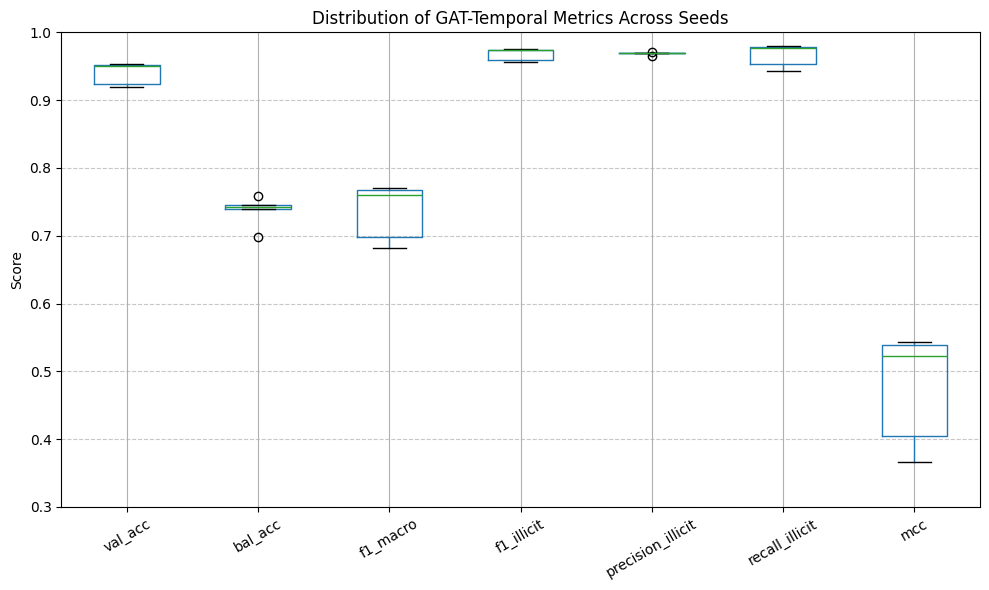

,Metric,Mean,Std,Formatted
0,val_acc,0.9396,0.0167,0.9396 ± 0.0167
1,bal_acc,0.7371,0.0227,0.7371 ± 0.0227
2,f1_macro,0.7357,0.0424,0.7357 ± 0.0424
3,f1_illicit,0.9678,0.0092,0.9678 ± 0.0092
4,precision_illicit,0.9692,0.0025,0.9692 ± 0.0025
5,recall_illicit,0.9665,0.0170,0.9665 ± 0.0170
6,mcc,0.4749,0.0832,0.4749 ± 0.0832


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

val_acc_list = metrics_logs["val_acc"]
for i in range(len(seed_metrics)):
    seed_metrics[i]["val_acc"] = val_acc_list[i]

df = pd.DataFrame(seed_metrics)
main_metrics = ['val_acc', 'bal_acc', 'f1_macro', 'f1_illicit', 'precision_illicit', 'recall_illicit', 'mcc']

means = df[main_metrics].mean()
stds = df[main_metrics].std()

plt.figure(figsize=(8, 5))
plt.bar(main_metrics, means, yerr=stds, capsize=5)
plt.ylim(0.3, 1.0)
plt.title(f"{model_name} Metrics Across Seeds (Mean ± Std)")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
df[main_metrics].boxplot()
plt.ylim(0.3, 1.0)
plt.title(f"Distribution of {model_name} Metrics Across Seeds")
plt.xticks(rotation=30)
plt.ylabel("Score")
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

summary_table = pd.DataFrame({
    "Metric": main_metrics,
    "Mean": means.round(4).values,
    "Std": stds.round(4).values,
    "Formatted": [f"{m:.4f} ± {s:.4f}" for m, s in zip(means, stds)]
}).set_index("Metric").loc[main_metrics].reset_index()

display(summary_table)


### 5.6 Class Wise Precision/Recall/F1

In [8]:
summarize_classification_report(y_true_all, y_pred_all)


Legit (0) Metrics:
precision: 0.5109 ± 0.1140
recall: 0.5077 ± 0.0343
f1-score: 0.5037 ± 0.0680

Illicit (1) Metrics:
precision: 0.9692 ± 0.0022
recall: 0.9665 ± 0.0152
f1-score: 0.9678 ± 0.0082


### 5.7 FP/FN Indices

In [9]:
save_fp_fn_indices(y_true_all, y_pred_all, seeds, model_dir)

### 5.8 FP/FN Time Stamp, Normalised and raw

In [11]:
data = attach_node_times(data, "../elliptic_bitcoin_dataset/elliptic_txs_features.csv")


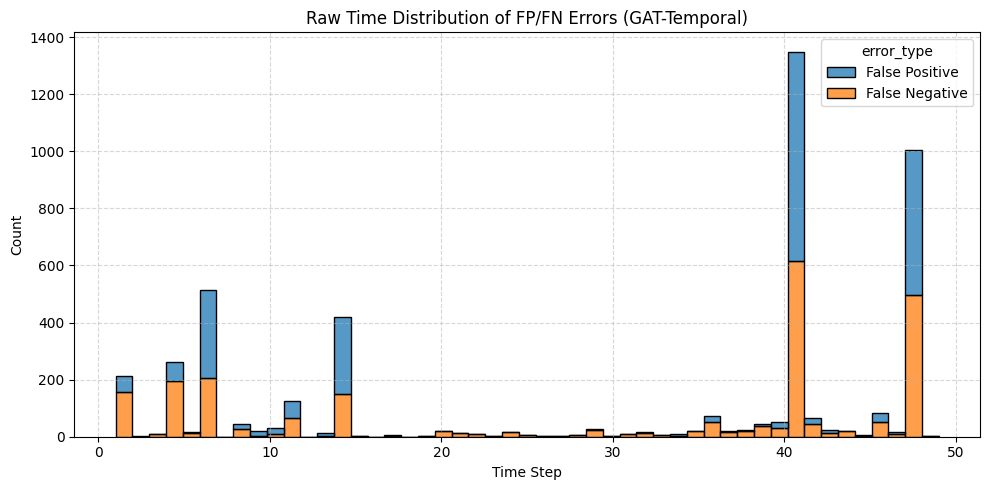

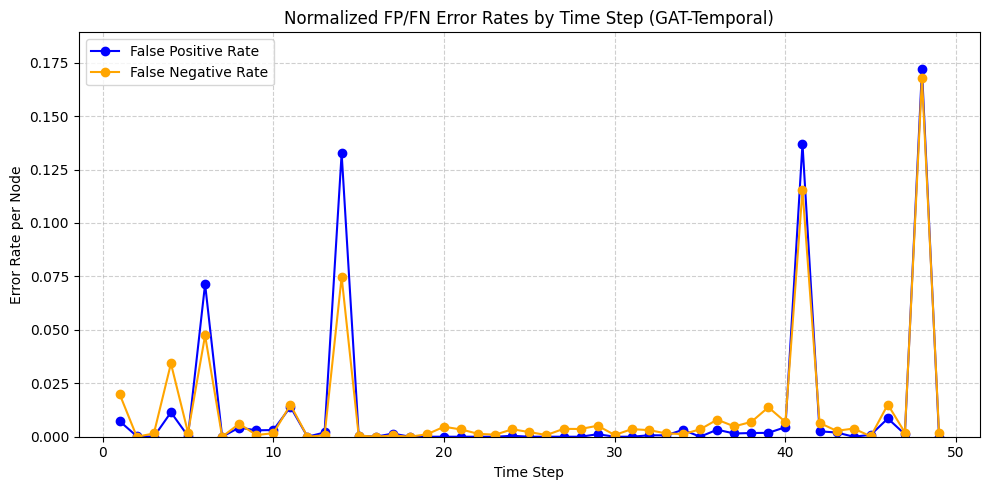

In [12]:
plot_fp_fn_time_distributions(data, seeds, model_dir, model_name=model_name)


## 6. Save into JSON

In [13]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
from evaluation_pipeline import export_full_evaluation_to_json

# --------------------------------------------
# Reconstruct confusion matrices (per seed)
# --------------------------------------------
conf_matrices = [
    confusion_matrix(y_true_all[i], y_pred_all[i])
    for i in range(len(seeds))
]

# --------------------------------------------
# Reconstruct FP/FN counts + time distributions
# using saved indices and timestamps
# --------------------------------------------
model_dir = "../model_temporal/GAT"  # <-- change per model
fp_counts, fn_counts = [], []
fp_time_all, fn_time_all = [], []

timestamps = data.node_times.cpu().numpy()

for seed in seeds:
    base = os.path.join(model_dir, f"seed_{seed}")
    fp_idx = np.load(os.path.join(base, "fp_indices.npy"))
    fn_idx = np.load(os.path.join(base, "fn_indices.npy"))

    fp_counts.append(len(fp_idx))
    fn_counts.append(len(fn_idx))

    fp_time_all.extend(timestamps[fp_idx])
    fn_time_all.extend(timestamps[fn_idx])

# Convert to JSON-compatible native Python types
fp_time_all = [int(t) for t in fp_time_all]
fn_time_all = [int(t) for t in fn_time_all]

# --------------------------------------------
# Final export to JSON files
# --------------------------------------------
export_full_evaluation_to_json(
    seed_metrics=seed_metrics,
    conf_matrices=conf_matrices,
    fp_counts=fp_counts,
    fn_counts=fn_counts,
    fp_time_all=fp_time_all,
    fn_time_all=fn_time_all,
    output_dir=model_dir
)
